# Imbalanced Classification for Fraud Detection - Part 2
## Statistical Analysis of Big Data

Amanda Magzal

***

# Table of Contents
## 1 [Introduction](#section1)

## 2 [Setup](#section2)

## 3 [Sampling Methods](#section3)

### 3.1 [Original Data](#section3.1)
* 3.1.1 [Logistic Regression](#section3.1.1)
* 3.1.2 [SVM - Linear Kernel](#section3.1.2)
* 3.1.3 [Random Forest](#section3.1.3)
* 3.1.4 [Gradient Tree Boosting](#section3.1.4)

### 3.2 [SMOTE](#section3.2)
* 3.2.1 [Logistic Regression](#section3.2.1)
* 3.2.2 [SVM - Linear Kernel](#section3.2.2)
* 3.2.3 [Random Forest](#section3.2.3)
* 3.2.4 [Gradient Tree Boosting](#section3.2.4)

### 3.3 [Random Oversampling](#section3.3)
* 3.3.1 [Logistic Regression](#section3.3.1)
* 3.3.2 [SVM - Linear Kernel](#section3.3.2)
* 3.3.3 [Random Forest](#section3.3.3)
* 3.3.4 [Gradient Tree Boosting](#section3.3.4)

### 3.4 [Random Undersampling](#section3.4)
* 3.4.1 [Logistic Regression](#section3.4.1)
* 3.4.2 [SVM - Linear Kernel](#section3.4.2)
* 3.4.3 [Random Forest](#section3.4.3)
* 3.4.4 [Gradient Tree Boosting](#section3.4.4)

## 4 [Comparison](#section4)

***

# 1 Introduction <a class="anchor" id="section1"></a>

In this project, I study imbalanced classification and its impact on classification algorithms.

In part 1, I developed a statistical model for imbalanced classification, and used a Monte Carlo simulation in order to study via training-testing procedures the classification accuracy of logistic regression, taking into account the model I developed.

In part 2, I explore different sampling methods used to improve the performance of machine learning algorithms in identification of the minority class.

***

# 2 Setup <a class="anchor" id="section2"></a>

In this section, I setup the libraries and data used for this part of the project. The data wranglig is identical to part 1.

In [1]:
# import relevant libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [2]:
# import data
df = pd.read_csv('credit_dataset.csv')
df.head().style.set_properties(**{'text-align': 'center'}).set_table_styles([dict(selector='th', props=[('text-align', 'center')])])

,Unnamed: 0,ID,GENDER,CAR,REALITY,NO_OF_CHILD,INCOME,INCOME_TYPE,EDUCATION_TYPE,FAMILY_TYPE,HOUSE_TYPE,FLAG_MOBIL,WORK_PHONE,PHONE,E_MAIL,FAMILY SIZE,BEGIN_MONTH,AGE,YEARS_EMPLOYED,TARGET
0,0,5008806,M,Y,Y,0,112500.000000,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,2.000000,29,59,3,0
1,1,5008808,F,N,Y,0,270000.000000,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,1.000000,4,52,8,0
2,2,5008809,F,N,Y,0,270000.000000,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,1.000000,26,52,8,0
3,3,5008810,F,N,Y,0,270000.000000,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,1.000000,26,52,8,0
4,4,5008811,F,N,Y,0,270000.000000,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,1.000000,38,52,8,0


In [3]:
# select features
new_df = df[["GENDER", "REALITY", "INCOME_TYPE", "FAMILY_TYPE", "YEARS_EMPLOYED", "TARGET"]]

In [4]:
# divide to features and label
features = new_df.drop("TARGET", axis=1)
label = new_df.TARGET

In [5]:
# create dummy variables
dummy_data = pd.get_dummies(features, columns={"GENDER", "REALITY", "INCOME_TYPE", "FAMILY_TYPE"}, drop_first=True)
features = dummy_data.copy()

In [6]:
# scaling
scaler = StandardScaler()
scaled = pd.DataFrame(scaler.fit_transform(features), columns = features.columns)
scaled.columns = features.columns
features = scaled

In [7]:
# features df
features.head().style.set_properties(**{'text-align': 'center'}).set_table_styles([dict(selector='th', props=[('text-align', 'center')])])

,YEARS_EMPLOYED,REALITY_Y,FAMILY_TYPE_Married,FAMILY_TYPE_Separated,FAMILY_TYPE_Single / not married,FAMILY_TYPE_Widow,INCOME_TYPE_Pensioner,INCOME_TYPE_State servant,INCOME_TYPE_Student,INCOME_TYPE_Working,GENDER_M
0,-0.655447,0.725866,0.659917,-0.248968,-0.398543,-0.153693,-0.022749,-0.327675,-0.019951,0.780311,1.282408
1,0.124085,0.725866,-1.515342,-0.248968,2.509141,-0.153693,-0.022749,-0.327675,-0.019951,-1.281541,-0.779783
2,0.124085,0.725866,-1.515342,-0.248968,2.509141,-0.153693,-0.022749,-0.327675,-0.019951,-1.281541,-0.779783
3,0.124085,0.725866,-1.515342,-0.248968,2.509141,-0.153693,-0.022749,-0.327675,-0.019951,-1.281541,-0.779783
4,0.124085,0.725866,-1.515342,-0.248968,2.509141,-0.153693,-0.022749,-0.327675,-0.019951,-1.281541,-0.779783


***

# 3 Sampling Methods <a class="anchor" id="section3"></a>

In this section, I apply different classification algorithms to the data, using 3 different sampling methods: SMOTE, Random Oversampling, and Random Undersampling. For each method I apply Logistic Regression, SVM (with a linear kernel), Random Forest, and Gradient Tree Boosting.

With the dataset being extremely imbalanced, I've decided to use three metrics to compare the different models. 

1. Sensitivity: refers to the ability to correctly predict positive obseravtions.

$$\text{Sensitivity} = \frac{\text{True Positive}}{\text{True Positive} + \text{False Negative}}$$

2. Specificity: refers to the ability to correctly predict negative obseravtions.

$$\text{Specificity} = \frac{\text{True Negative}}{\text{True Negative} + \text{False Positive}}$$

3. Accuracy: refers to the ability to correctly predict both positive and negative obseravtions.

$$\text{Accuracy} = \frac{\text{True Positive} + \text{True Negative}}{\text{True Positive} + \text{True Negative} + \text{False Positive} + \text{False Negative}}$$

I defined three methods that will be used for all the models:

The `get_metrics` method is used to calculate the sensitivity, specificity and accuracy of a given estimator, provided the train and test data. In addition, it creates a confusion matrix.

In [8]:
def get_metrics(X_train, X_test, y_train, y_test, estimator):
    
    # fit estimator
    estimator.fit(X_train, y_train)
    
    # get best estimator
    best = estimator.best_estimator_

    # predict
    y_pred_test = best.predict(X_test)
    
    # Get true/false for whether a fraud actually occurred
    actual_pos = y_test == 1
    actual_neg = y_test == 0
    
    # Get confusion matrix
    mat = metrics.confusion_matrix(y_test, y_pred_test)
    true_neg, false_pos, false_neg, true_pos = mat.ravel()
    
    # Calculate accuracy
    accuracy = np.mean(y_pred_test == y_test)
    
    # Calculate sensitivity and specificity
    sensitivity = true_pos / np.sum(actual_pos)
    specificity = true_neg / np.sum(actual_neg)
    
    # define scores list
    scores = [sensitivity, specificity, accuracy]
    
    # create confusion matrix
    sns.heatmap(mat, annot=True, cbar=False, cmap="Blues",
                linecolor="Black", linewidth=0.2, fmt="1")
    plt.xlabel("Predicted", fontsize=12)
    plt.ylabel("True", fontsize=12)
    plt.title("Confusion Matrix", fontsize=14)
    
    return scores, plt

The `estimators` method is used to define the estimators and parameters for each sampling method.

In [9]:
def estimators():
    
    # logistic regression
    parameters_grid = {'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 1.25, 1.5]}
    model = LogisticRegression(fit_intercept=True)
    log_reg = GridSearchCV(estimator=model, param_grid=parameters_grid, cv=10, n_jobs=-1)
    
    # svm
    parameters_grid = {'C': [0.1, 0.5, 1, 5, 10]}
    model = SVC(kernel='linear')
    svm = GridSearchCV(estimator=model, param_grid=parameters_grid, cv=10, n_jobs=-1)
    
    # random forest
    parameters_grid = {
        'max_depth': [50, 100],
        'min_samples_leaf': [1, 2],
        'min_samples_split': [2, 3],
        'n_estimators': [50, 100],
        'max_features': [5, 10]
    }
    model = RandomForestClassifier()
    random_forest = GridSearchCV(estimator=model, param_grid=parameters_grid, cv=10, n_jobs=-1)
    
    # gradient boosting
    parameters_grid = {
        'max_depth': [3, 5],
        'min_samples_leaf': [1, 2],
        'min_samples_split': [3, 5],
        'n_estimators': [50, 100],
        'max_features': [5, 10]
    }
    model = GradientBoostingClassifier()
    gradient_boosting = GridSearchCV(estimator=model, param_grid=parameters_grid, cv=10, n_jobs=-1)
    
    return log_reg, svm, random_forest, gradient_boosting

The `display_df` method is used to create and display the dataframe for the sensitivity scores.

In [10]:
def display_df(scores):
    df = pd.DataFrame(scores).T
    df = df.rename(index={0: 'Score'}, columns={0: 'Sensitivity', 1: 'Specificity', 2:'Accuracy'})
    return(df)

***

## 3.1 Original Data (without sampling) <a class="anchor" id="section3.1"></a>

In [11]:
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.25, random_state=10)

In [12]:
log_reg, svm, random_forest, gradient_boosting = estimators()

### 3.1.1 Logistic Regression <a class="anchor" id="section3.1.1"></a>

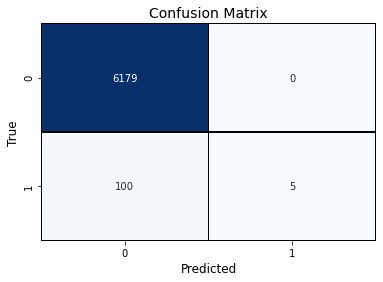

In [13]:
scores, plt = get_metrics(X_train, X_test, y_train, y_test, log_reg)

In [14]:
og_res = display_df(scores)
og_res

,Sensitivity,Specificity,Accuracy
Score,0.047619,1.0,0.984087


### 3.1.2 SVM <a class="anchor" id="section3.1.2"></a>

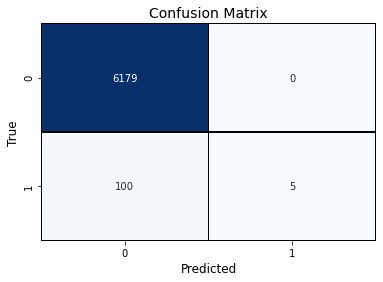

In [15]:
scores, plt = get_metrics(X_train, X_test, y_train, y_test, svm)

In [16]:
temp = display_df(scores)
temp

,Sensitivity,Specificity,Accuracy
Score,0.047619,1.0,0.984087


In [17]:
og_res = og_res.append(temp)

### 3.1.3 Random Forest <a class="anchor" id="section3.1.3"></a>

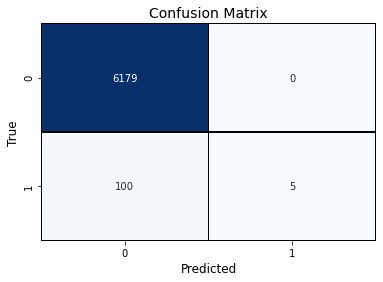

In [18]:
scores, plt = get_metrics(X_train, X_test, y_train, y_test, random_forest)

In [19]:
temp = display_df(scores)
temp

,Sensitivity,Specificity,Accuracy
Score,0.047619,1.0,0.984087


In [20]:
og_res = og_res.append(temp)

### 3.1.4 Gradient Tree Boosting <a class="anchor" id="section3.1.4"></a>

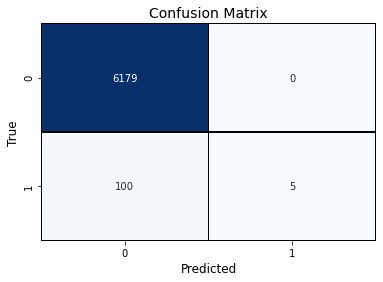

In [21]:
scores, plt = get_metrics(X_train, X_test, y_train, y_test, gradient_boosting)

In [22]:
temp = display_df(scores)
temp

,Sensitivity,Specificity,Accuracy
Score,0.047619,1.0,0.984087


In [23]:
og_res = og_res.append(temp)

***

## 3.2 SMOTE <a class="anchor" id="section3.2"></a>

SMOTE first selects a minority class instance at random and finds its k nearest minority class neighbors. The synthetic instance is then created by choosing one of the k nearest neighbors b at random and connecting a and b to form a line segment in the feature space. The synthetic instances are generated as a convex combination of the two chosen instances a and b.

In [24]:
X_smote, y_smote = SMOTE().fit_resample(features, label)

In [25]:
print("X", X_smote.shape)
print("y", y_smote.shape)

X (49424, 11)
y (49424,)


In [26]:
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_smote, y_smote, test_size=0.25, random_state=10)

In [27]:
log_reg, svm, random_forest, gradient_boosting = estimators()

### 3.2.1 Logistic Regression <a class="anchor" id="section3.2.1"></a>

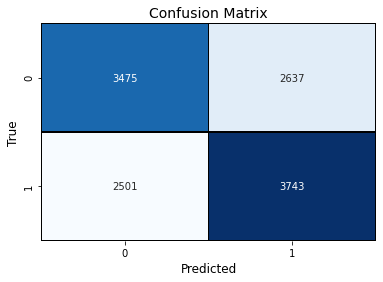

In [28]:
scores, plt = get_metrics(X_train_smote, X_test_smote, y_train_smote, y_test_smote, log_reg)

In [29]:
smote_res = display_df(scores)
smote_res

,Sensitivity,Specificity,Accuracy
Score,0.599455,0.568554,0.58417


### 3.2.2 SVM <a class="anchor" id="section3.2.2"></a>

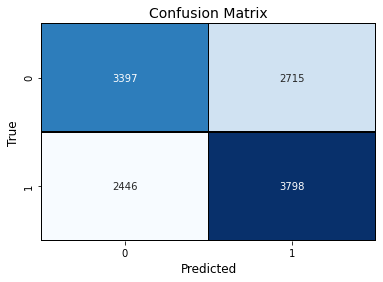

In [30]:
scores, plt = get_metrics(X_train_smote, X_test_smote, y_train_smote, y_test_smote, svm)

In [31]:
temp = display_df(scores)
temp

,Sensitivity,Specificity,Accuracy
Score,0.608264,0.555792,0.582308


In [32]:
smote_res = smote_res.append(temp)

### 3.2.3 Random Forest <a class="anchor" id="section3.2.3"></a>

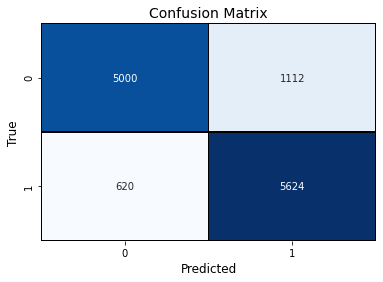

In [33]:
scores, plt = get_metrics(X_train_smote, X_test_smote, y_train_smote, y_test_smote, random_forest)

In [34]:
temp = display_df(scores)
temp

,Sensitivity,Specificity,Accuracy
Score,0.900705,0.818063,0.859825


In [35]:
smote_res = smote_res.append(temp)

### 3.2.4 Gradient Tree Boosting <a class="anchor" id="section3.2.4"></a>

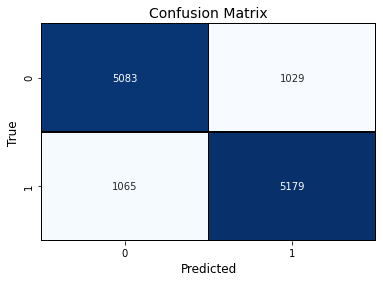

In [36]:
scores, plt = get_metrics(X_train_smote, X_test_smote, y_train_smote, y_test_smote, gradient_boosting)

In [37]:
temp = display_df(scores)
temp

,Sensitivity,Specificity,Accuracy
Score,0.829436,0.831643,0.830528


In [38]:
smote_res = smote_res.append(temp)

***

## 3.3 Random Oversampling <a class="anchor" id="section3.3"></a>

Random oversampling replicates the data of the minority class to form a balanced dataset.

In [39]:
X_over, y_over = RandomOverSampler().fit_resample(features, label)

In [40]:
print("X", X_over.shape)
print("y", y_over.shape)

X (49424, 11)
y (49424,)


In [41]:
X_train_over, X_test_over, y_train_over, y_test_over = train_test_split(X_over, y_over, test_size=0.25, random_state=10)

In [42]:
log_reg, svm, random_forest, gradient_boosting = estimators()

### 3.3.1 Logistic Regression <a class="anchor" id="section3.3.1"></a>

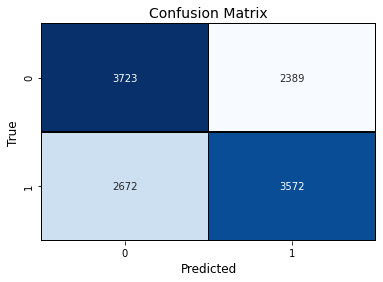

In [43]:
scores, plt = get_metrics(X_train_over, X_test_over, y_train_over, y_test_over, log_reg)

In [44]:
over_res = display_df(scores)
over_res

,Sensitivity,Specificity,Accuracy
Score,0.572069,0.60913,0.590401


### 3.3.2 SVM <a class="anchor" id="section3.3.2"></a>

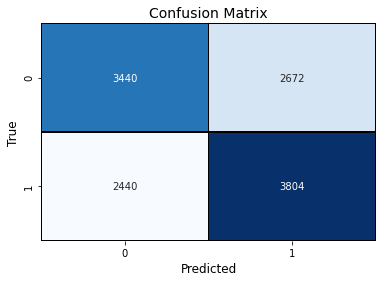

In [45]:
scores, plt = get_metrics(X_train_over, X_test_over, y_train_over, y_test_over, svm)

In [46]:
temp = display_df(scores)
temp

,Sensitivity,Specificity,Accuracy
Score,0.609225,0.562827,0.586274


In [47]:
over_res = over_res.append(temp)

### 3.3.3 Random Forest <a class="anchor" id="section3.3.3"></a>

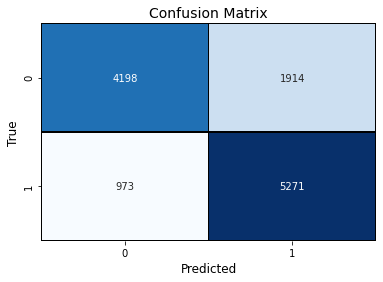

In [48]:
scores, plt = get_metrics(X_train_over, X_test_over, y_train_over, y_test_over, random_forest)

In [49]:
temp = display_df(scores)
temp

,Sensitivity,Specificity,Accuracy
Score,0.84417,0.686846,0.766348


In [50]:
over_res = over_res.append(temp)

### 3.3.4 Gradient Tree Boosting <a class="anchor" id="section3.3.4"></a>

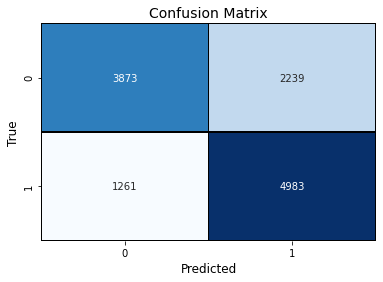

In [51]:
scores, plt = get_metrics(X_train_over, X_test_over, y_train_over, y_test_over, gradient_boosting)

In [52]:
temp = display_df(scores)
temp

,Sensitivity,Specificity,Accuracy
Score,0.798046,0.633671,0.716737


In [53]:
over_res = over_res.append(temp)

***

## 3.4 Random Undersampling <a class="anchor" id="section3.4"></a>

Random oversampling removes data of the majority class to form a balanced dataset. This may lead to a great loss of information.

In [54]:
X_under, y_under = RandomUnderSampler().fit_resample(features, label)

In [55]:
print("X", X_under.shape)
print("y", y_under.shape)

X (844, 11)
y (844,)


In [56]:
X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(X_under, y_under, test_size=0.25, random_state=10)

In [57]:
log_reg, svm, random_forest, gradient_boosting = estimators()

### 3.4.1 Logistic Regression <a class="anchor" id="section3.4.1"></a>

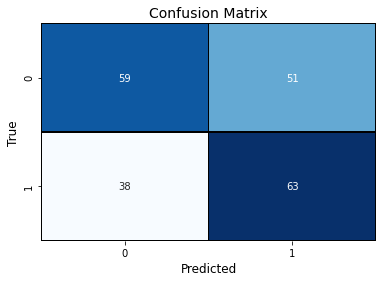

In [58]:
scores, plt = get_metrics(X_train_under, X_test_under, y_train_under, y_test_under, log_reg)

In [59]:
under_res = display_df(scores)
under_res

,Sensitivity,Specificity,Accuracy
Score,0.623762,0.536364,0.578199


### 3.4.2 SVM <a class="anchor" id="section3.4.2"></a>

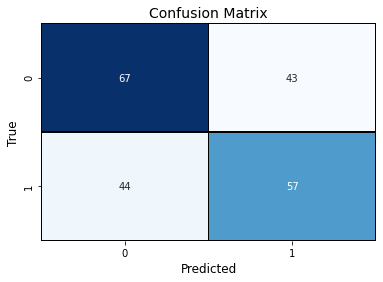

In [60]:
scores, plt = get_metrics(X_train_under, X_test_under, y_train_under, y_test_under, svm)

In [61]:
temp = display_df(scores)
temp

,Sensitivity,Specificity,Accuracy
Score,0.564356,0.609091,0.587678


In [62]:
under_res = under_res.append(temp)

### 3.4.3 Random Forest <a class="anchor" id="section3.4.3"></a>

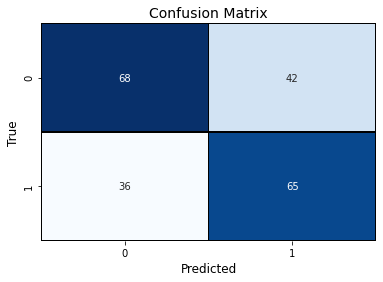

In [63]:
scores, plt = get_metrics(X_train_under, X_test_under, y_train_under, y_test_under, random_forest)

In [64]:
temp = display_df(scores)
temp

,Sensitivity,Specificity,Accuracy
Score,0.643564,0.618182,0.630332


In [65]:
under_res = under_res.append(temp)

### 3.4.4 Gradient Tree Boosting <a class="anchor" id="section3.4.4"></a>

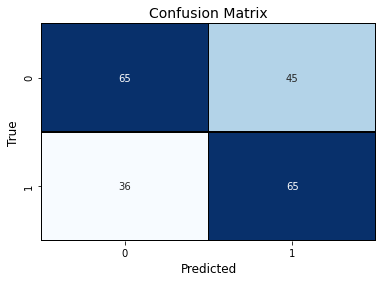

In [66]:
scores, plt = get_metrics(X_train_under, X_test_under, y_train_under, y_test_under, gradient_boosting)

In [67]:
temp = display_df(scores)
temp

,Sensitivity,Specificity,Accuracy
Score,0.643564,0.590909,0.616114


In [68]:
under_res = under_res.append(temp)

***

# 4 Comparison <a class="anchor" id="section4"></a>

The following boxplots show the results of each metric per method.

In [69]:
og_res['Method'] = 'None'
smote_res['Method'] = 'SMOTE'
over_res['Method'] = 'Oversampling'
under_res['Method'] = 'Undersampling'

In [70]:
res = og_res.append(smote_res)
res = res.append(over_res)
res = res.append(under_res)

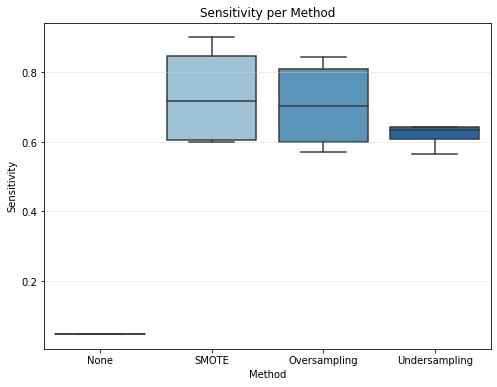

In [71]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Method', y='Sensitivity', data=res, palette='Blues')
plt.title('Sensitivity per Method')
plt.grid(axis='y', alpha=0.5, color='lightgrey')
plt.show()

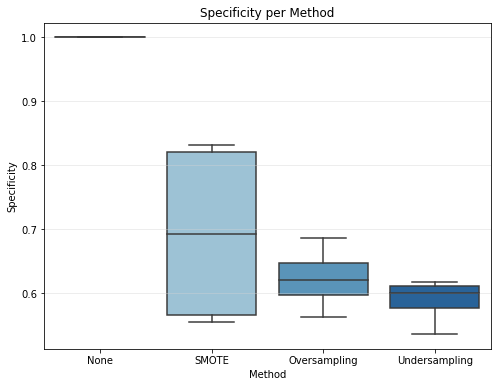

In [72]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Method', y='Specificity', data=res, palette='Blues')
plt.title('Specificity per Method')
plt.grid(axis='y', alpha=0.5, color='lightgrey')
plt.show()

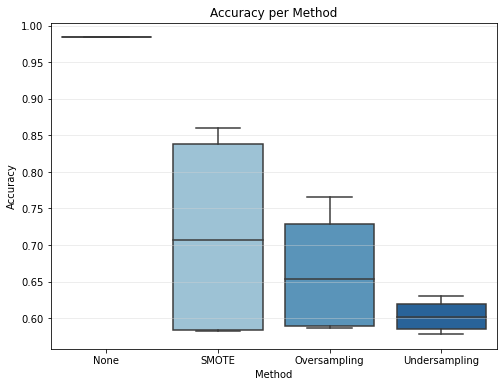

In [73]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Method', y='Accuracy', data=res, palette='Blues')
plt.title('Accuracy per Method')
plt.grid(axis='y', alpha=0.5, color='lightgrey')
plt.show()

### Conclusion

Applying the algorithms on the original dataset (section 3.1) resulted in perfect prediction of the majority class (aka not fraud), which then led to very high accuracy scores. However, the sensitivity score was extremely low - around 0.047 - which means that the models were very bad at predicting the fraud cases.

Using the SMOTE method (section 3.2) resulted in much better predictions when applying the Random Forest and Gradient Tree Boosting algorithms, which had sensitivity scores of 0.90 and 0.83, respectively. However, the Logistic Regression and SVM algorithms did not perform as well, both having a sensitivity score of around 0.6. Still, they did a better job in identifying the minority class using the SMOTE method, compared to the original dataset.

The random oversampling method (section 3.3) led to an overall better identification of the minority class. The best score was obtained by the Random Forest algorithm - 0.84, followed by the Gradient Tree Boosting with 0.79. The other algorithms did not perform as well. The sensitivity score for SVM was 0.61, and Logistic Regression was the worst, with 0.57.

The random undersampling method (section 3.4) led to an overall better identification of the minority class as well but it did not identify the majority class so well (i.e. the specifity scores were lower). The best score was again obtained by the Random Forest and Gradient Tree Boosting algorithms with 0.64, followed by Logistic Regression with 0.62, and SVM was the worst, with sensitivity score of 0.56.

Overall, it seems like oversampling methods paired with the Random Forest algorithm lead to better results, compared to undersampling, which suffer from a great loss of information.

***